In [6]:
import numpy as np
import pandas as pd
import splat
import popsims
from astropy.coordinates import SkyCoord, Galactic
from popsims.galaxy import Pointing, volume_calc, create_pop
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
#sns.set_style("darkgrid", {"axes.facecolor": ".95"})

#plt.style.use('fivethirtyeight')
#plt.style.use('dark_background')

from  matplotlib.colors import Normalize
import astropy.units as u
import popsims
import matplotlib
from tqdm import tqdm
from tqdm import tqdm
import matplotlib as mpl 
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['xtick.labelsize'] =20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['figure.titlesize'] = 20

splat.initializeStandards(all=True)

%matplotlib inline

In [7]:
import numpy
import shapey
import splat
import popsims

In [8]:
fig_folder='/users/caganze/research/popsims/figures/'
data_folder='/users/caganze/research/popsims/data/'

In [9]:
AREA=4.4*(u.arcmin**2)*124

In [13]:
H=350
FOV={'jswt': AREA}
#make magnitude cuts
grism_cuts={'JSWT':{ 'NIRISS_F115W':[1, 27.],\
                    'NIRISS_F150W':[1, 27.] }}

#the goods north field
#OINTS={'jswt':SkyCoord(ra="12:36:55", dec="62:14:15", unit=(u.hourangle, u.deg))}
ls= np.concatenate([np.random.uniform(-180, 20, 62), np.random.uniform(20, 180, 62)])
bs= np.concatenate([np.random.uniform(-90, 20, 62), np.random.uniform(20, 90, 62)])
POINTS={'jswt': SkyCoord(l=ls*u.degree, b=bs*u.degree, frame='galactic')}

In [14]:
#local luminosity function
#LF=pd.read_pickle(popsims.DATA_FOLDER+'/lf_scales.pkl')

In [15]:
def scale_to_lf(data):
    scale=data.scale.iloc[0]
    return scale
        

def make_cuts(df,  cut_dict, survey='JSWT'):
    dcts=grism_cuts[survey]
    return df[np.logical_and.reduce([df[k]< dcts[k][1] for k in dcts.keys()])]

def get_average_distance_limits(p, cut_dict, survey='JSWT'):
    p.mag_limits=grism_cuts[survey.upper()]
    return dict(pd.DataFrame(p.distance_limits).applymap(lambda x: x[1]).median(axis=1))

In [16]:
def sample_pointings(scaleH, scaleL, NSAMPLE, volume_kind='exp'):
    ds=[]
    for c in tqdm(POINTS['jswt']):
        p= Pointing(coord=c,density= volume_kind)
        ds.append(p.draw_distances(1, 50000, \
                    scaleH, scaleL, nsample=1e4))
    ds=np.array(ds).flatten()
    return  np.random.choice(ds, int(NSAMPLE), replace=True)

def compute_normalized_volumes(scaleH, scaleL, volume_kind='exp'):
    vs=dict(zip(range(17, 42),np.zeros(len(range(17, 42)))))
    for c in tqdm(POINTS['jswt']):
        p=Pointing(coord=c,density= volume_kind)
        for s in range(17, 42):
            vs[s]+=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                    0, DIST_LIMITS[s],scaleH, scaleL, \
                                   kind= volume_kind)
    
    return  vs

In [17]:
p=Pointing(coord=POINTS['jswt'])
p.mag_limits=grism_cuts['JSWT']
DIST_LIMITS=get_average_distance_limits(p, grism_cuts['JSWT'], survey='JSWT')

In [19]:
VOLUMES={'thin_200': compute_normalized_volumes(200,2600, volume_kind='exp'),
         'thin_400':compute_normalized_volumes(400, 2600, volume_kind='exp'),
         'thick':compute_normalized_volumes(900, 3600, volume_kind='exp'),
         'halo': compute_normalized_volumes(900, 3600, volume_kind='spheroid'),
}

100%|████████████████████████████████████████| 124/124 [00:00<00:00, 240.91it/s]


In [20]:
#VOLUMES

In [21]:
def get_numbers(coord, fov, cuts, **kwargs):
    NCOUNTS={}
    spgrid=kwargs.get('spgrid', [20, 30])
    scaleH=kwargs.get('h', 350)
    scaleL=kwargs.get('l', 2600)
    kind=kwargs.get('kind', 'exp')
    survey=kwargs.get('survey', 'survey')
    model=kwargs.get('model', 'burrows1997')
    mag_keys=kwargs.get('mag_keys', [])
    
    volume_kind=kind
    if kind!='exp':
        volume_kind='spheroid'

    galactic_dists=sample_pointings(scaleH, scaleL, 1e6, volume_kind= volume_kind)
    
    dff=create_pop(bfraction=0.2,\
                         model= model,\
                           l=list(POINTS['jswt'].galactic.l.radian),
                           b=list(POINTS['jswt'].galactic.b.radian),
                           absmag_keys=mag_keys, \
                           nsample=int(1e6),
                           distances=galactic_dists,
                  poptype='dwarfs')
    
    scale=np.nanmedian(dff.scale)
    
    df_cut= make_cuts(dff,cuts, survey=survey)
    nxbr_counts=[]
    vols=[]
    
    #compute volumes
    p= Pointing(coord=POINTS['jswt'][0])
    dct= get_average_distance_limits(p, cuts, survey=survey)
    for spt in tqdm(spgrid):
        sptvol=volume_calc(p.coord.galactic.l.radian,\
                                   p.coord.galactic.b.radian,
                                   1., DIST_LIMITS[spt],scaleH, scaleL, \
                           kind= volume_kind)*(fov.to(u.radian**2)).value
        df_select= df_cut[np.logical_and(df_cut.spt>=spt, df_cut.spt<spt+0.99)]


        nbrs=len(df_select)
        cnbrs=nbrs*sptvol*scale
        vols.append(sptvol)
        nxbr_counts.append(cnbrs)
    NCOUNTS['counts']=np.array(nxbr_counts)
    NCOUNTS['volumes']=np.array(vols)
    NCOUNTS['data']=df_cut
    return NCOUNTS
        



In [22]:
def get_numbers_by_model(model='burrows1997'):
    thin_number_200=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=200, model=model)
    
    thin_number_400=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=400, model=model)
    
    thick_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', h=900, l=3600, model=model)
    
    halo_number=get_numbers(POINTS['jswt'], FOV['jswt'], grism_cuts['JSWT'],
                         mag_keys=grism_cuts['JSWT'].keys(),\
                        spgrid=np.arange(17, 42), survey='JSWT', kind='halo', model=model)
    
    return {'thin_200': thin_number_200, 'thin_400': thin_number_400, \
            'thick': thick_number, 'halo': halo_number}

In [23]:
#b97=get_numbers_by_model(model='burrows1997')
b01=get_numbers_by_model(model='burrows2001')
b03=get_numbers_by_model(model='baraffe2003')

100%|██████████████████████████████████████████| 25/25 [00:00<00:00, 805.96it/s]


In [24]:
import collections
isinstance(list(POINTS['jswt'].galactic.l.radian), collections.Sequence)

True

In [64]:
b01['thick']['data'].keys()

Index(['NIRISS_F115W', 'abs_NIRISS_F115W', 'NIRISS_F150W', 'abs_NIRISS_F150W',
       'mass', 'age', 'temperature', 'luminosity', 'is_binary', 'spt',
       'prim_spt', 'sec_spt', 'pri_mass', 'sec_mass', 'prim_luminosity',
       'sec_luminosity', 'scale', 'scale_unc', 'scale_times_model', 'd', 'l',
       'b', 'r', 'z', 'U', 'V', 'W'],
      dtype='object')

[Text(0.5, 0, 'Log distance (pc)')]

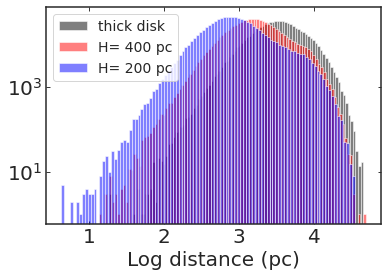

In [81]:
fig, ax=plt.subplots()
_=ax.hist( np.log10(b01['thick']['data']['d']), label='thick disk', color='k', bins=100, alpha=0.5, log=True)
_=ax.hist(  np.log10(b01['thin_400']['data']['d']), label='H= 400 pc', color='r', bins=100, alpha=0.5, log=True)
_=ax.hist(  np.log10(b01['thin_200']['data']['d']), label='H= 200 pc', color='b', bins=100,alpha=0.5,  log=True)
plt.legend(fontsize=14)
ax.set(xlabel='Log distance (pc)')

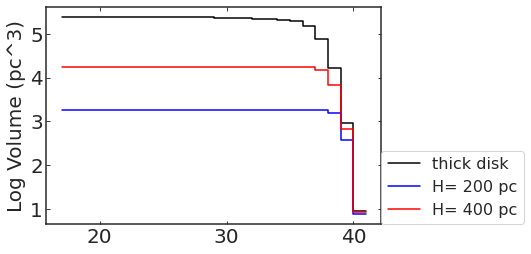

In [83]:
#plot volumes
fig, ax=plt.subplots()
#ax.plot(np.arange(17, 42), b01['halo']['volumes'], label='Halo', c='b')
ax.step(np.arange(17, 42), np.log10(b01['thick']['volumes']), label='thick disk', c='k')
ax.step(np.arange(17, 42), np.log10(b01['thin_200']['volumes']), label='H= 200 pc',c='b')
ax.step(np.arange(17, 42), np.log10(b01['thin_400']['volumes']), label='H= 400 pc',  c='r')
ax.set( ylabel='Log Volume (pc^3)')
ax.legend(fontsize=16, loc=(1, 0))

In [56]:
len(b01['thin_200']['data'])

1097913

In [86]:
def get_scaled_histogram(data, bins):
    scl= data.scale.median()
    counts, edges=np.histogram(data.spt.values, bins=bins)
    return scl*counts

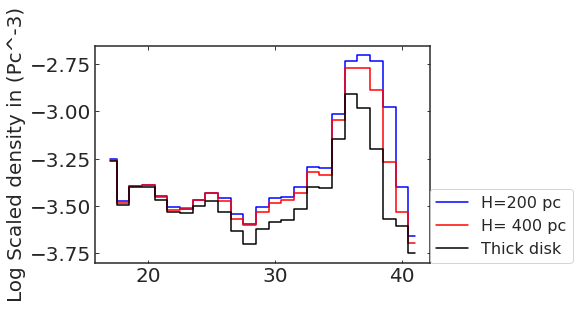

In [90]:

fig, ax=plt.subplots()

ax.step(range(17, 42), np.log10(get_scaled_histogram(b01['thin_200']['data'], 
                                                 bins=range(17, 43))), \
        where='mid',label='H=200 pc', c='b')

ax.step(range(17, 42),  np.log10(get_scaled_histogram(b01['thin_400']['data'], \
                                                                        \
                                              bins=range(17, 43))),  \
        where='mid', label='H= 400 pc', c='r')

ax.step(range(17, 42),  np.log10(get_scaled_histogram(b01['thick']['data'], \
                                                                        \
                                              bins=range(17, 43))),  \
        where='mid', label='Thick disk', c='k')

#ax.step(range(17, 42),  0.0025*(get_scaled_histogram(b01['halo']['data'], \
#                                                                        \
#                                              bins=range(17, 43))), 
#            where='mid',  label='Halo', c='k')

ax.set(ylabel='Log Scaled density in (Pc^-3)')
ax.legend(fontsize=16, loc=(1, 0))

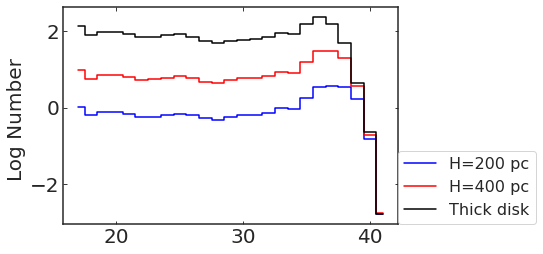

In [92]:
#spectral type distributions
fig, ax=plt.subplots()
ax.step(range(17, 42),  np.log10(b01['thin_200']['volumes']*(get_scaled_histogram(b01['thin_200']['data'], 
                                                 bins=range(17, 43)))),  where='mid', \
        label='H=200 pc', c='b')

ax.step(range(17, 42),  np.log10(b01['thin_400']['volumes']*(get_scaled_histogram(b01['thin_400']['data'], \
                                                        bins=range(17, 43)))),  where='mid',\
        label='H=400 pc', c='r')

ax.step(range(17, 42),  np.log10(b01['thick']['volumes']*(get_scaled_histogram(b01['thick']['data'], \
                                                                         bins=range(17, 43)))),  \
        label='Thick disk', where='mid', c='k')

ax.set(ylabel='Log Number ')
ax.legend(fontsize=16, loc=(1, 0))

In [31]:
def tick_function(locs, distlimits):
   
    return ["{:.1f} ".format(distlimits[x]/1000) for x in locs]

In [32]:
#np.nansum(halo_number['counts']*(1/400)), np.nansum(thick_number['counts']*(0.12))
conversion_area=1/AREA

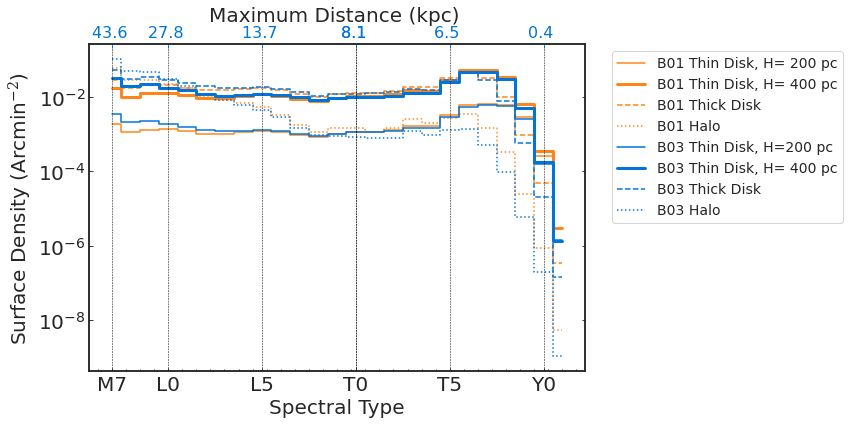

In [52]:
fig, ax=plt.subplots(figsize=(12, 6))


plt.step(np.arange(17, 42), b01['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  label='B01 Thin Disk, H= 200 pc')

plt.step(np.arange(17, 42), b01['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#FF851B',  linewidth=3, label='B01 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b01['thick']['counts']*0.12*conversion_area, \
        where='mid', linestyle='--', color='#FF851B',   label='B01 Thick Disk')

plt.step(np.arange(17, 42), b01['halo']['counts']*(1/400)*conversion_area,\
         where='mid',  linestyle='dotted', color='#FF851B',  label='B01 Halo')


plt.step(np.arange(17, 42), b03['thin_200']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  label='B03 Thin Disk, H=200 pc')

plt.step(np.arange(17, 42), b03['thin_400']['counts']*conversion_area, \
         where='mid', linestyle='-', color='#0074D9',  linewidth=3, label='B03 Thin Disk, H= 400 pc')

plt.step(np.arange(17, 42), b03['thick']['counts']*0.12*conversion_area, \
         where='mid', linestyle='--', color='#0074D9', label='B03 Thick Disk')
plt.step(np.arange(17, 42), b03['halo']['counts']*(1/400)*conversion_area,\
         where='mid', linestyle='dotted', color='#0074D9', label='B03 Halo')


ax.set(xlabel='Spectral Type', \
       ylabel=r'Surface Density (Arcmin$^{-2}$)', xticks=[17, 20, 25, 30, 35, 40],
      xticklabels=['M7', 'L0', 'L5', 'T0', 'T5','Y0'], yscale='log')
ax.grid(False, which='both', axis='x')

ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
new_tick_locations = np.array([17, 20, 25, 30, 30, 35, 40])
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations, DIST_LIMITS ), fontsize=16)
ax2.tick_params(colors='#0074D9', which='both') 
ax2.set_xlabel('Maximum Distance (kpc) ')
ax2.grid()
ax.legend(bbox_to_anchor=(1.04,1), loc="upper left", fontsize=14)
plt.tight_layout()
#ax.grid( axis='y',  which='major')
ax.minorticks_on()
plt.savefig(fig_folder+'/jswt_counts.pdf', dpi=600)

In [34]:
b03['thin_400']['counts']/b03['thin_200']['counts']

array([9.48368547, 9.34938977, 9.60295364, 9.36758807, 9.48740542,
       9.38056143, 9.15136079, 9.42023289, 9.29721574, 9.28707091,
       9.46946751, 8.9537053 , 9.09229384, 8.83357512, 8.79636385,
       8.88914881, 8.44630681, 9.00508367, 8.84944018, 8.81041061,
       7.96020804, 5.48502635, 1.99761852, 1.15561129, 0.94047021])

In [35]:
spts= [x for x in np.arange(17, 42)]

In [36]:
#number report
num_rp=pd.DataFrame()
#
num_rp['max_distance']= [round(DIST_LIMITS[x]) for x in np.arange(17, 42)]
num_rp['thin_200_b01']= b01['thin_200']['counts']*conversion_area.value
num_rp['thin_200_b03']= b03['thin_200']['counts']*conversion_area.value
num_rp['thin_400_b01']= b01['thin_400']['counts']*conversion_area.value
num_rp['thin_400_b03']= b03['thin_400']['counts']*conversion_area.value

num_rp['thick_b01']=b01['thick']['counts']*(0.12)*conversion_area.value
num_rp['thick_b03']=b03['thick']['counts']*(0.12)*conversion_area.value

num_rp['halo_b01']=b01['halo']['counts']*(1/400)*conversion_area.value
num_rp['halo_b03']=b03['halo']['counts']*(1/400)*conversion_area.value
num_rp['average']= num_rp[['thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].mean(axis=1)
num_rp.index=spts

for c in num_rp.columns:
    num_rp.loc['total', c]= np.nansum(num_rp[c].loc[spts])
    num_rp.loc['average', c]= np.nanmedian(num_rp[c].loc[spts])

In [37]:
num_rp

,max_distance,thin_200_b01,thin_200_b03,thin_400_b01,thin_400_b03,thick_b01,thick_b03,halo_b01,halo_b03,average
17,43590.0,0.001881,0.003547,0.017683,0.033639,2.935288e-02,5.529701e-02,5.939772e-02,1.083853e-01,0.038648
18,37117.0,0.001134,0.002126,0.010448,0.019879,1.718342e-02,3.175025e-02,2.952495e-02,5.033584e-02,0.020298
19,31999.0,0.001345,0.002316,0.012977,0.022238,2.126427e-02,3.590018e-02,2.960097e-02,4.808669e-02,0.021716
20,27755.0,0.001365,0.001950,0.013004,0.018265,2.123197e-02,2.977915e-02,2.336226e-02,3.068234e-02,0.017455
21,24114.0,0.001195,0.001616,0.011279,0.015330,1.823040e-02,2.428468e-02,1.749222e-02,1.980885e-02,0.013655
22,20935.0,0.001046,0.001325,0.009639,0.012430,1.573529e-02,1.985384e-02,1.066972e-02,1.254264e-02,0.010405
23,18155.0,0.001028,0.001201,0.009803,0.010989,1.553610e-02,1.813331e-02,8.245659e-03,8.560732e-03,0.009187
24,15745.0,0.001142,0.001222,0.010836,0.011516,1.680451e-02,1.759680e-02,6.846422e-03,6.056795e-03,0.009003
25,13695.0,0.001246,0.001338,0.011843,0.012439,1.785572e-02,1.860375e-02,5.596567e-03,4.497892e-03,0.009178
26,11989.0,0.001175,0.001252,0.010724,0.011627,1.575164e-02,1.683414e-02,3.325388e-03,2.899207e-03,0.007948


In [38]:
#num_rp=num_rp.applymap(lambda x: np.round(x, 4))

In [39]:
num_rp.columns
#remember to change last column to total

Index(['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03',
       'average'],
      dtype='object')

In [40]:
num_rp[['max_distance', 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03', 'average']].to_latex('~/desktop/jswt_preds.tex', index=True)

In [41]:
num_rp.loc[17:19].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([0.00436, 0.00799, 0.04111, 0.07576, 0.0678 , 0.12295, 0.11852,
       0.20681])

In [42]:
num_rp.loc[20:29].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([0.01105, 0.01289, 0.10321, 0.12002, 0.15603, 0.18174, 0.07995,
       0.08837])

In [43]:
num_rp.loc[30:39].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([0.03242, 0.02932, 0.24117, 0.21654, 0.20933, 0.1825 , 0.01665,
       0.00793])

In [44]:
num_rp.loc[40:41].sum()[[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([2.7e-04, 1.6e-04, 3.5e-04, 1.8e-04, 5.0e-05, 2.0e-05, 0.0e+00,
       0.0e+00])

In [45]:
num_rp.loc['total'][[ 'thin_200_b01', 'thin_200_b03', 'thin_400_b01',
       'thin_400_b03', 'thick_b01', 'thick_b03', 'halo_b01', 'halo_b03']].apply(lambda x: np.round(x, 5)).values

array([0.0481 , 0.05035, 0.38585, 0.4125 , 0.43321, 0.48721, 0.21513,
       0.30311])

In [46]:
num_rp.loc['total']*(AREA/124)

max_distance    1.462080e+06
thin_200_b01    2.116379e-01
thin_200_b03    2.215601e-01
thin_400_b01    1.697733e+00
thin_400_b03    1.815003e+00
thick_b01       1.906128e+00
thick_b03       2.143731e+00
halo_b01        9.465564e-01
halo_b03        1.333670e+00
average         1.284502e+00
Name: total, dtype: float64

In [47]:
1.4*124*4.4

763.84

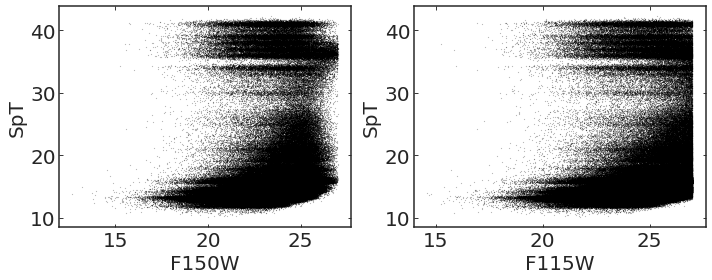

In [48]:
fig, (ax, ax1)=plt.subplots(ncols=2, figsize=(10, 4))
d=b01['halo']['data']
ax.scatter(d.NIRISS_F150W, d.spt, s=0.01, c='k')
ax1.scatter(d.NIRISS_F115W, d.spt, s=0.01, c='k')
plt.tight_layout()
ax.set(xlabel='F150W', ylabel='SpT')
ax1.set(xlabel='F115W', ylabel='SpT')
plt.tight_layout()

In [49]:
AREA

<Quantity 545.6 arcmin2>